In [1]:
%load_ext autoreload
%autoreload 2

In [108]:
# from ariadne.util.deeppcb import DeepPCBData, Defect, DefectType
from ariadne.util.datasets import DeepPCB
from ariadne.util.deeppcb import DefectType
from ariadne.util.datasets import DeepPCB
# from ariadne.util import showdefects
from ariadne.nn.util import show_results
from ariadne.cv import get_defect_blobs, featurize_region
# import ariadne.cv
from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np
import torch
from torch import nn, Tensor
import torchvision
import skimage as ski
import collections
from enum import IntEnum
from tqdm.notebook import tqdm
from sklearn import svm

import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rc('image', cmap='gray')

%matplotlib inline

In [83]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

[0, 0.24154589371980675, 0, 0, 0, 0, 0]
[0, 0, 0.2793103448275862, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0.1650390625, 0]
[0, 0, 0, 0, 0.14619883040935672, 0, 0]
[0, 0, 0, 0, 0, 0, 0.36391304347826087]
[0.11478260869565217, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.36391304347826087, 0, 0, 0]


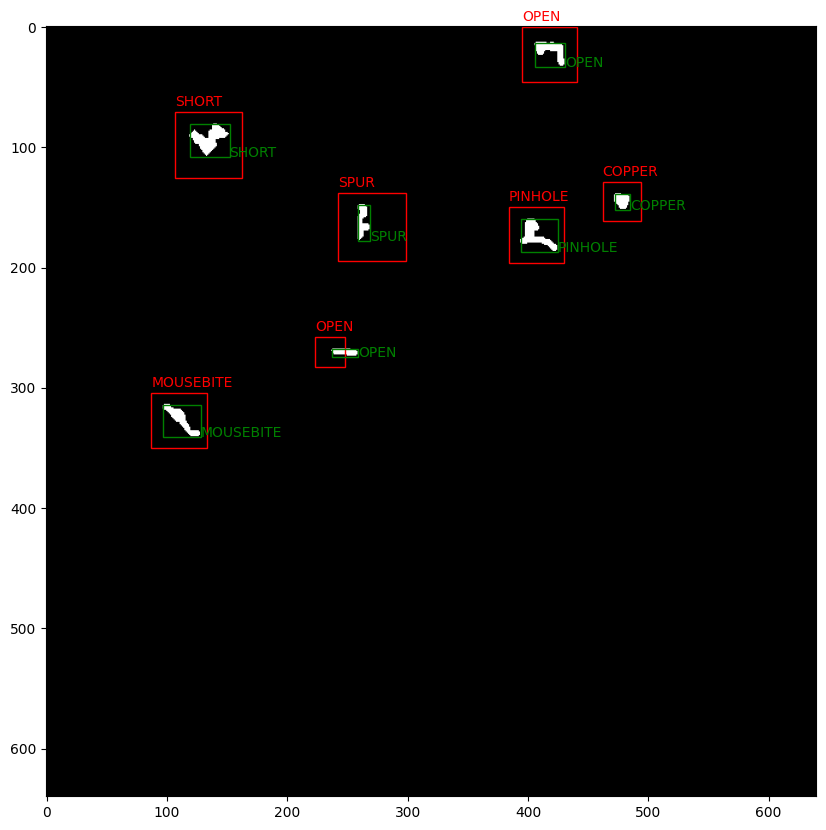

In [74]:
pair = ds.pairs[0]
annot = DeepPCBData._read_annot(pair['annotpath'])
img_obsv = np.asarray(Image.open(pair['obsvpath']).convert('1'))
img_tmpl = np.asarray(Image.open(pair['truthpath']).convert('1'))

img_pair = (img_tmpl, img_obsv)
blobs, labels, defect_mask = get_defect_blobs(img_pair)

fig, ax = showdefects(blobs, annot)

for region in ski.measure.regionprops(labels):
    minr, minc, maxr, maxc = region.bbox
    rect = patches.Rectangle((minc,minr), maxc-minc, maxr-minr,
                            facecolor='none', edgecolor='g')

    ious = [bb_intersection_over_union([minc, minr, maxc, maxr], defect.aslist()) for defect in annot]
    best_match_idx = np.argmax(ious)
    print(ious)
    if np.isclose(ious[best_match_idx], 0.):
        print('cant match; skip in train')
        continue

    matched_defect = annot[best_match_idx]

    ax.add_patch(rect)
    ax.text(maxc, maxr, f'{matched_defect.ty.name}', color='g')

    features = featurize_region(img_pair, labels, region)
    if features is None:
        print('failed to featurize')
        continue

In [75]:
ds = DeepPCB()

TEST_SPLIT = 500
trainset = ds.pairs[:-TEST_SPLIT]
testset = ds.pairs[-TEST_SPLIT:]

In [76]:
X = []
y = []

for pair in trainset:
    annot = DeepPCBData._read_annot(pair['annotpath'])
    img_obsv = np.asarray(Image.open(pair['obsvpath']).convert('1'))
    img_tmpl = np.asarray(Image.open(pair['truthpath']).convert('1'))

    img_pair = (img_tmpl, img_obsv)
    blobs, labels, defect_mask = get_defect_blobs(img_pair)

    # fig, ax = showdefects(blobs, annot)

    for region in ski.measure.regionprops(labels):
        minr, minc, maxr, maxc = region.bbox
        # rect = patches.Rectangle((minc,minr), maxc-minc, maxr-minr,
        #                         facecolor='none', edgecolor='g')

        ious = [bb_intersection_over_union([minc, minr, maxc, maxr], defect.aslist()) for defect in annot]
        best_match_idx = np.argmax(ious)
        # print(ious)
        if np.isclose(ious[best_match_idx], 0.):
            print('cant match; skip in train')
            continue

        matched_defect = annot[best_match_idx]

        # ax.add_patch(rect)
        # ax.text(maxc, maxr, f'{matched_defect.ty.name}', color='g')

        features = featurize_region(img_pair, labels, region)
        if features is None:
            print('failed to featurize')
            continue

        X.append(features)
        y.append(matched_defect)

cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
failed to featurize
failed to featurize
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
failed to featurize
cant match; skip in train
cant match; skip in train
failed to featurize
failed to featurize
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip in train
cant match; skip

In [64]:
X_ = np.array(X)
y_ = [d.ty.name for d in y]
clf = svm.SVC(kernel='rbf')
clf.fit(X_, y_)

SVC()

In [72]:
for pair in testset:
    annot = DeepPCBData._read_annot(pair['annotpath'])
    img_obsv = np.asarray(Image.open(pair['obsvpath']).convert('1'))
    img_tmpl = np.asarray(Image.open(pair['truthpath']).convert('1'))

    img_pair = (img_tmpl, img_obsv)
    blobs, labels, defect_mask = get_defect_blobs(img_pair)

    for region in ski.measure.regionprops(labels):
        # minr, minc, maxr, maxc = region.bbox

        features = featurize_region(img_pair, labels, region)
        if features is None:
            print('failed to featurize')
            continue

        print(region.bbox, clf.predict(features.reshape(1, -1)))
    break

(31, 27, 68, 30) ['SHORT']
(100, 27, 185, 30) ['SHORT']
(157, 79, 192, 83) ['OPEN']
(182, 258, 222, 261) ['OPEN']
(233, 306, 250, 316) ['PINHOLE']
(270, 27, 302, 30) ['SHORT']
(272, 211, 287, 223) ['COPPER']
(284, 293, 289, 337) ['SHORT']
(331, 195, 343, 204) ['OPEN']
(387, 27, 413, 31) ['SHORT']
(416, 28, 538, 31) ['SHORT']
(463, 205, 471, 216) ['SPUR']
(526, 150, 533, 164) ['MOUSEBITE']
(563, 28, 640, 31) ['SHORT']


In [107]:
DEEPPCB_ROOT = Path('/Users/moon/git/DeepPCB')
class PILToTensor(nn.Module):
    def forward(
        self, tmpl_image, obsv_image, target,
    ):
        tmpl_image = np.asarray(tmpl_image.convert('RGB'))
        obsv_image = np.asarray(obsv_image.convert('RGB'))
        return tmpl_image, obsv_image, target

dataset      = DeepPCB(DEEPPCB_ROOT, txf)
dataset_test = DeepPCB(DEEPPCB_ROOT, txf)

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
TEST_SPLIT = 500 # of 1500 image pairs
dataset = torch.utils.data.Subset(dataset, indices[:-TEST_SPLIT])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-TEST_SPLIT:])

def collate_fn(x):
    return x[0]

data_loader = torch.utils.data.DataLoader(dataset,
    batch_size=1, shuffle=True,
    collate_fn=collate_fn,
    num_workers=0)

data_loader_test = torch.utils.data.DataLoader(dataset_test,
    batch_size=1, shuffle=True,
    collate_fn=collate_fn,
    num_workers=0)

NameError: name 'nn' is not defined

In [102]:
next(iter(data_loader))

(<PIL.Image.Image image mode=1 size=640x640>,
 <PIL.Image.Image image mode=1 size=640x640>,
 {'boxes': tensor([[181., 223., 232., 265.],
          [379.,  49., 405., 114.],
          [250., 153., 283., 184.],
          [407., 484., 438., 542.],
          [299., 226., 338., 270.],
          [314., 495., 347., 535.]]),
  'area': tensor([2142., 1690., 1023., 1798., 1716., 1320.]),
  'labels': tensor([1, 2, 3, 4, 5, 6]),
  'image_id': tensor([44000030])})

In [105]:
for tmpl_image, obsv_image, targets in data_loader:
    print(tmpl_image)
    img_pair = (tmpl_image, obsv_image)
    
    blobs, labels, defect_mask = get_defect_blobs(img_pair)
    # print(targets)
    
    break

<PIL.Image.Image image mode=1 size=640x640 at 0x177063EE0>


TypeError: unsupported operand type(s) for ^: 'Image' and 'Image'